# Mulitnomial Logistic Regression in PyTorch

Your task will be to:

* Implement and optimize multinomial logistic regression using Pytorch (with and without Autograd)

Goal is to:

* Understand and learn basics of PyTorch
* Revise multinomial logistic regression

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tqdm
import json

import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

from keras.datasets import fashion_mnist
from keras.utils import np_utils

%matplotlib inline
import matplotlib.pylab as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

Using Theano backend.


In [2]:
# Get FashionMNIST (see 1b_FMNIST.ipynb for data exploration)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Logistic regression needs 2D data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 0-1 normalization
x_train = x_train / 255.
x_test = x_test / 255.

# For simplicity - implicit bias
x_train = np.concatenate([np.ones_like(x_train[:, 0:1]), x_train], axis=1)
x_test = np.concatenate([np.ones_like(x_test[:, 0:1]), x_test], axis=1)

# Convert to Torch Tensor. Just to avoid boilerplate code later
x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

# Use only first 1k examples. Just for notebook to run faster
x_train, y_train = x_train[0:1000], y_train[0:1000]
x_test, y_test = x_test[0:1000], y_test[0:1000]

# Why not Numpy

Ref: http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture8.pdf

<img src="https://github.com/gmum/nn2018/raw/master/lab/fig/2/GPUvsCPU.png">

# PyTorch mini tutorial

Ref: http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py

PyTorch has 3 layers of abstraction

<img width=300 src="https://github.com/gmum/nn2018/raw/master/lab/fig/3/cake.jpg">

# First layer: torch Tensor

First layer is basically numpy, but with ability to execute on GPU

In [26]:
a = torch.IntTensor([2, 3, 4])
b = torch.IntTensor([3, 4, 5])
m = a * b  # element-wise product
print(m.numpy())  # convert to the numpy array [ 6 12 20]

[ 6 12 20]


In [27]:
x = torch.rand(5, 3)
print(x)


 0.6849  0.8932  0.0675
 0.8580  0.6672  0.3234
 0.1506  0.2567  0.7283
 0.4159  0.8175  0.8290
 0.4293  0.0646  0.3651
[torch.FloatTensor of size 5x3]



In [28]:
y = torch.rand(5, 3)
print(x + y)


 1.2296  1.5225  0.3067
 1.0169  1.3049  1.1821
 0.8348  0.8888  0.8082
 1.3100  1.3078  1.0437
 0.5525  0.9666  1.2275
[torch.FloatTensor of size 5x3]



In [29]:
print(torch.add(x, y))


 1.2296  1.5225  0.3067
 1.0169  1.3049  1.1821
 0.8348  0.8888  0.8082
 1.3100  1.3078  1.0437
 0.5525  0.9666  1.2275
[torch.FloatTensor of size 5x3]



In [30]:
## Just like numpy! Amazing!
print(x[:, 1])


 0.8932
 0.6672
 0.2567
 0.8175
 0.0646
[torch.FloatTensor of size 5]



## GPU execution by modifying flag

In [31]:
if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    x + y
else:
    print("No GPU!")

No GPU!


# Second layer: Variable, computation graph and autograd

torch.autograd.Variable uses internally torch.Tensor as .data field.

When computing using wrapped in torch.Variable tensors, PyTorch creates computational graph for us

In [32]:
# Get torchviz (might not work on some systems)
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot, make_dot_from_trace

  Cloning https://github.com/szagoruyko/pytorchviz to /private/var/folders/8p/fn8p9w8n307fzb00y_q531wc0000gn/T/pip-asxs8L-build


In [64]:
w = Variable(torch.ones(2, 2), requires_grad=True)
x = Variable(torch.ones(2, 4), requires_grad=True)
y = w.mm(x) + 2

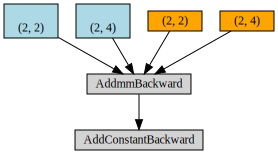

In [65]:
make_dot(y)

## Autograd

torch.Autograd works on torch.Variable

In [47]:
x = Variable(torch.ones(2, 2), requires_grad=True)
print(x)
y = x + 2
print(y)
print(y.grad_fn)
z = y * y * 3
out = z.mean()
print(z, out)
out.backward()
print(x.grad) # dout/dx :)

Variable containing:
 1  1
 1  1
[torch.FloatTensor of size 2x2]

Variable containing:
 3  3
 3  3
[torch.FloatTensor of size 2x2]

(Variable containing:
 27  27
 27  27
[torch.FloatTensor of size 2x2]
, Variable containing:
 27
[torch.FloatTensor of size 1]
)
Variable containing:
 4.5000  4.5000
 4.5000  4.5000
[torch.FloatTensor of size 2x2]



In [68]:
w = Variable(torch.ones(2, 2), requires_grad=True)
x = Variable(torch.ones(2, 4), requires_grad=False)
y = (w.mm(x) + 2).mean()
grad,  = torch.autograd.grad(y, w, create_graph=True, retain_graph=True)

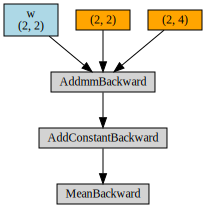

In [69]:
make_dot(y, params={"w": w})

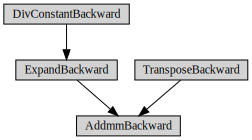

In [70]:
make_dot(grad, params={"w": w, "x": x})

# Third layer: torch.nn

Not much about it now. We will work much closer with later.

In [72]:
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = Variable(torch.randn(1,8))
y = model(x)

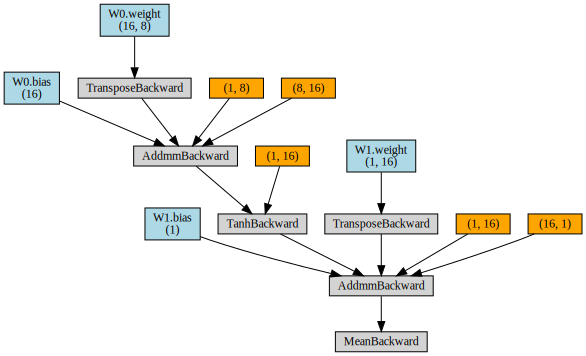

In [73]:
make_dot(y.mean(), params=dict(model.named_parameters()))

# Multinomial logistic regression

(Using PyTorch)

## Useful equations

Let $D$ denote input dimension, $K$ denote number of classes. Class probabilities are given by the softmax distribution:

<br>
<font size=4>
$ p(\textbf{y} = k | \textbf{x}, \textbf{w}) = \frac{\exp(\langle\textbf{w}_k, \textbf{x}\rangle)}{\sum_i^{K} \exp(\langle\textbf{w}_i, \textbf{x}\rangle)}$
</font>

, where $w \in \mathbb{R}^{(D,K)}$, $w_k$ denotes $k^{th}$ row of the $w$ matrix. For $K=2$ equivalent to the binomial logistic regression discussed in the previous notebook:

<br>
<font size=4>
$ p(\textbf{y} | \textbf{x}, \textbf{w}) = \sigma(\langle\textbf{w}, \textbf{x}\rangle)$
</font>

Same as in binary case, loss is the cross-entropy loss:

<br>
<font size=4>
$ L(\textbf{w}) = \sum_i y_i \log(p(\textbf{y_i} | \textbf{x_i}, \textbf{w}))$
</font>


## Implement helper functions 

Hint: very similar to 2a_logistic_regression

In [86]:
def cross_entropy_loss(y_pred, y):
    """
    Parameters
    ----------
    y_pred: torch.Variable, shape: (batch_size, K)
        Probabiities
    y: torch.Variable, shape: (batch_size,)
        Correct classes
    
    Returns
    -------
    loss: torch.Variable, shape: (1, )
        Cross entropy loss
    """
    # Hint: use y as indexes to retrieve appropriate columns of y_pred
    ??

def softmax(h):
    """
    Parameters
    ----------
    h: torch.Variable, shape: (batch_size, K)
        Logits
    
    Returns
    -------
    y_pred: torch.Variable, shape: (batch_size, K)
        Softmax on h
    """
    ??

def forward(x, w):
    return softmax(x.mm(w))

def evaluate(w):
    x = Variable(x_test)
    y_test_pred = forward(x, w).data.numpy()
    return np.mean(y_test_pred.argmax(axis=1) == y_test.numpy())

In [13]:
# Asserts to help you implement the functions.
D = 785
K = 10

x = Variable(x_train[0:100], requires_grad=False) # No grad wrt to data
y = Variable(y_train[0:100], requires_grad=False) # No grad wrt to data 
w = Variable(torch.randn(D, K), requires_grad=True) # Grad wrt to weights!
y_pred = softmax(x.mm(w))

yours = cross_entropy_loss(y_pred, y).data[0]
correct = nn.CrossEntropyLoss()(x.mm(w), y).data[0]
assert np.allclose(yours, correct, atol=0.01)

yours = softmax(x.mm(w)).data.numpy()
correct = F.softmax(x.mm(w)).data.numpy()
assert np.allclose(yours, correct, atol=0.01)

NameError: name 'softmax' is not defined

In [57]:
def train_logistic_regression(lr=0.1, n_epochs=100, batch_size=100):
    """
    Parameters
    ----------
    lr: float
        Learning rate used in SGD
    n_epochs: int
        Number of epochs to train
    use_autograd: bool
        If true will use PyTorch autograd
    
    Returns
    -------
    w: np.array, shape: (D_in, D_out)
        Found parameters
    """
    
    n_epochs = 100
    batch_size = 100
    learning_rate = 0.1
    use_autograd = True

    # 784 + bias -> 10 model
    D, K = 784 + 1, 10 

    # Define all Variables used in the computation
    dtype = torch.FloatTensor
    x = Variable(torch.randn(batch_size, D).type(dtype), requires_grad=False) # No grad wrt to data
    y = Variable(torch.randn(batch_size, K).type(dtype), requires_grad=False) # No grad wrt to data
    w = Variable(torch.randn(D, K).type(dtype), requires_grad=True) # Grad wrt to weights!

    loss_history = []
    for epoch in tqdm.tqdm(range(n_epochs), total=n_epochs):    
        for batch in range(len(x_train) // batch_size):
            # Sample data
            x_batch = x_train[batch*batch_size:(batch+1)*batch_size]
            y_batch = y_train[batch*batch_size:(batch+1)*batch_size]

            x_batch = Variable(x_batch.type(torch.FloatTensor), requires_grad=False)
            y_batch = Variable(y_batch.type(torch.LongTensor), requires_grad=False)

            y_pred = ?? # Hint: use forward
            loss = ?? # Hint: cross_entropy_loss

            if batch == 0:
                loss_history.append(loss.data.numpy())

            # Compute grad_w
            grad_w = ?? # Hint: use w.grad and backward. Google if needed.

            # Update weights using gradient descent
            w.data -= # Hint: use learning rate and computed gradient

            ?? # You need to zero gradients, before next batch.  Google if needed.

    plt.plot(loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    return w

# Tests

Each notebook will terminate with Tests section. This will automatically grade and assign points.

Evaluation results:
{'test1': 1}


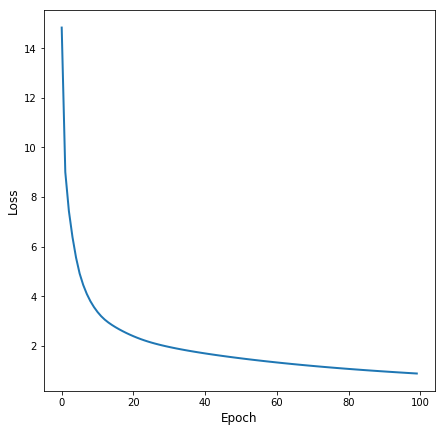

In [84]:
result = {}
result['test1'] = int(evaluate(train_logistic_regression(n_epochs=100, lr=0.1)) > 0.6)
print("Evaluation results:\n===========")
print(result)
json.dump(result, open("2b_pytorch.json", "w"))